# Análisis de la Varianza

In [12]:
# https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

In [13]:
import pandas as pd
import numpy as np
import random
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns

In [14]:
from scipy import stats
import scikit_posthocs as sp

In [15]:
data = pd.read_csv("Drug_Consumption.csv")
# Control drug 'Semer'
data.drop("Semer", axis=1, inplace=True)

In [16]:
# limpieza de base de datos para su análisis
# asignando códigos
codes = {
    "CL6": 1, "CL5": 1, "CL4": 1,
    "CL3": 0.5,
    "CL2": 0, "CL1": 0, "CL0": 0
}

datos = (
    data
    .assign(
        # renombrando para reagrupar
        Consumption = lambda k: k.iloc[:,13:]
                                .replace(codes)
                                .sum(axis=1),
        Age = lambda k: k.Age.replace({"55-64":"45+", "65+":"45+", "45-54":"45+"}),
        Education = lambda k: k.Education.replace(
            {
                "Left school at 18 years": "Left school at or before 18",
                "Left school at 16 years": "Left school at or before 18",
                "Left school at 17 years": "Left school at or before 18",
                "Left school before 16 years": "Left school at or before 18",
                "Masters degree": "Master or Doctorate degree",
                "Doctorate degree": "Master or Doctorate degree",
                "Some college or university, no certificate or degree":"Some co. or un. no certificate"
            }
        )
    )
    # seleccion de variables a estudiar
    [["Age", "Education", "Consumption"]]
)

### Análisis por grupos de Edad

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Número de entradas por grupo de Edad')

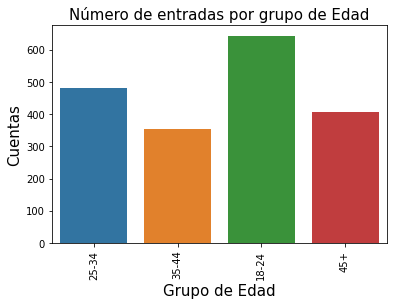

In [17]:
# Primer análisis
ax=sns.countplot(datos.Age)
plt.xticks(rotation=90);
plt.xlabel("Grupo de Edad", size=15)
plt.ylabel("Cuentas", size=15)
plt.title("Número de entradas por grupo de Edad", size=15)

In [18]:
muestra_age = [datos.query(f"Age == '{i}'").sample(300) for i in datos.Age.unique()]
sample_age = pd.concat(muestra_age, axis=0)

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


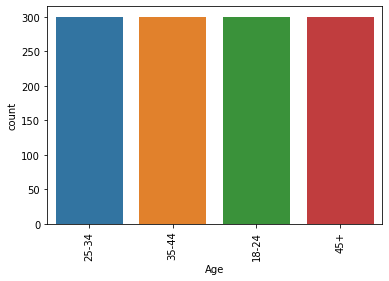

In [19]:
ax=sns.countplot(sample_age.Age)
plt.xticks(rotation=90);

In [20]:
# Individuos por grupo
groups = sample_age.groupby('Age').count().reset_index()
groups

,Age,Education,Consumption
0,18-24,300,300
1,25-34,300,300
2,35-44,300,300
3,45+,300,300


In [21]:
# Estadisticos de cada distribucion
res = rp.summary_cont(sample_age.groupby('Age'))
res

Consumption                                           
                N    Mean      SD      SE 95% Conf. Interval
Age                                                         
18-24         300  7.2467  2.8583  0.1650    6.9219   7.5714
25-34         300  5.2867  2.6548  0.1533    4.9850   5.5883
35-44         300  4.2467  1.9374  0.1119    4.0265   4.4668
45+           300  3.7533  1.4350  0.0829    3.5903   3.9164

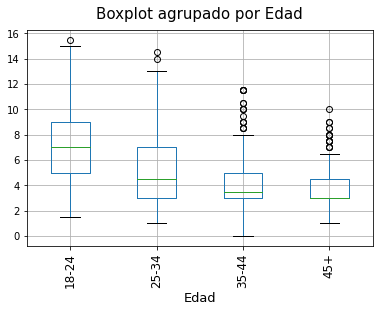

In [22]:
# prueba visual de las distribuciones y medias
sample_age.boxplot('Consumption',by='Age',rot=90)
plt.suptitle("Boxplot agrupado por Edad", size=15)
plt.xlabel("Edad", size=13)
plt.xticks(size=12)
plt.title("");

In [23]:
# Normalidad
#Normalidad prueba de Shapiro-Wilk
#Ho:Normalidad(p>0.05)
#H1: No normalidad (p<0.05)
#Normalidad en las variables
pg.normality(sample_age, dv='Consumption', group='Age')

,W,pval,normal
25-34,0.905559,9.199336e-13,False
35-44,0.825754,1.089460e-17,False
18-24,0.978735,1.952779e-04,False
45+,0.827046,1.265768e-17,False


In [24]:
# Varianza entre grupos
sample_age.groupby('Age')['Consumption'].var()

Age
18-24    8.169721
25-34    7.047982
35-44    3.753333
45+      2.059353
Name: Consumption, dtype: float64

In [26]:
#Homocedasticidad prueba de Levene (sin normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample_age, dv='Consumption', 
                    group='Age',method='levene')

,W,pval,equal_var
levene,46.410802,2.256792e-28,False


In [27]:
#Homocedasticidad prueba de Bartlett (con normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample_age, dv='Consumption', 
                    group='Age',method='bartlett')

,T,pval,equal_var
bartlett,161.379885,9.232823e-35,False


In [28]:
model =ols('Consumption ~ Age', data=sample_age).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Age,2154.080000,3.0,136.569348,4.366819e-76
Residual,6288.086667,1196.0,NaN,NaN


In [29]:
# %%Comparación múltiple Prueba de Tukey
comp = mc.MultiComparison(sample_age.Consumption, sample_age.Age)
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 18-24  25-34    -1.96   -0.0 -2.4416 -1.4784   True
 18-24  35-44     -3.0   -0.0 -3.4816 -2.5184   True
 18-24    45+  -3.4933   -0.0  -3.975 -3.0117   True
 25-34  35-44    -1.04    0.0 -1.5216 -0.5584   True
 25-34    45+  -1.5333   -0.0  -2.015 -1.0517   True
 35-44    45+  -0.4933 0.0423  -0.975 -0.0117   True
----------------------------------------------------


In [30]:
# la muesta de todos los grupos
groups = [i.Consumption.to_numpy() for i in muestra_age]

# prueba no parametrica, comparar con anova
stats.kruskal(*groups)

KruskalResult(statistic=281.77728999834886, pvalue=8.735044386245065e-61)

In [31]:
pht = sp.posthoc_conover(np.array(groups), p_adjust='bonferroni')
pht

,1,2,3,4
1,1.000000e+00,3.066883e-06,2.393454e-20,1.347223e-15
2,3.066883e-06,1.000000e+00,4.107984e-44,6.471109e-03
3,2.393454e-20,4.107984e-44,1.000000e+00,3.849390e-63
4,1.347223e-15,6.471109e-03,3.849390e-63,1.000000e+00


### Anális por nivel de Educación

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


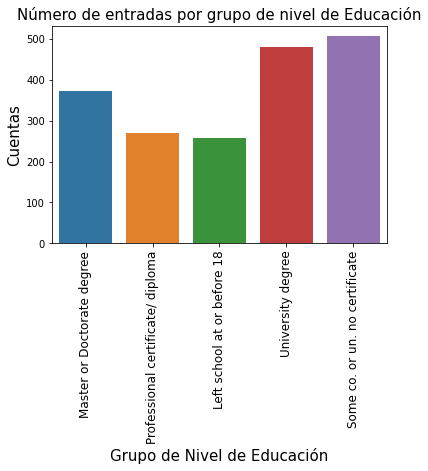

In [32]:
ax=sns.countplot(datos.Education)
plt.xticks(rotation=90, size=12)
plt.xlabel("Grupo de Nivel de Educación", size=15)
plt.ylabel("Cuentas", size=15)
plt.title("Número de entradas por grupo de nivel de Educación", size=15);

In [33]:
muestra_education = [datos.query(f"Education == '{i}'").sample(250) for i in datos.Education.unique()]
sample_education = pd.concat(muestra_education, axis=0)

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


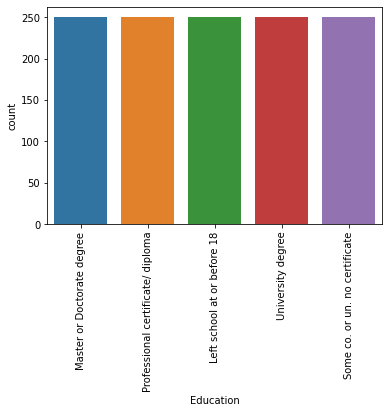

In [34]:
ax=sns.countplot(sample_education.Education)
plt.xticks(rotation=90);

In [35]:
# Individuos por grupo
groups = sample_education.groupby('Education').size().reset_index()
groups

,Education,0
0,Left school at or before 18,250
1,Master or Doctorate degree,250
2,Professional certificate/ diploma,250
3,Some co. or un. no certificate,250
4,University degree,250


In [36]:
# Estadisticos de cada distribucion
res = rp.summary_cont(sample_education.groupby('Education'))
res

Consumption                         \
                                            N   Mean      SD      SE   
Education                                                              
Left school at or before 18               250  5.660  2.6564  0.1680   
Master or Doctorate degree                250  4.418  2.4082  0.1523   
Professional certificate/ diploma         250  4.766  2.4036  0.1520   
Some co. or un. no certificate            250  7.026  2.7324  0.1728   
University degree                         250  4.670  2.6145  0.1654   

                                                      
                                  95% Conf. Interval  
Education                                             
Left school at or before 18          5.3291   5.9909  
Master or Doctorate degree           4.1180   4.7180  
Professional certificate/ diploma    4.4666   5.0654  
Some co. or un. no certificate       6.6856   7.3664  
University degree                    4.3443   4.9957

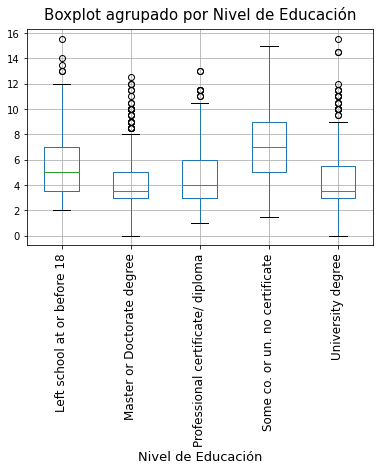

In [37]:
# prueba visual de las distribuciones y medias
sample_education.boxplot('Consumption',by='Education',rot=90)
plt.suptitle("Boxplot agrupado por Nivel de Educación", size=15)
plt.xlabel("Nivel de Educación", size=13)
plt.xticks(size=12)
plt.title("");

In [38]:
# Normalidad
#Normalidad prueba de Shapiro-Wilk
#Ho:Normalidad(p>0.05)
#H1: No normalidad (p<0.05)
#Normalidad en las variables
pg.normality(sample_education, dv='Consumption', group='Education')

,W,pval,normal
Master or Doctorate degree,0.800870,3.564884e-17,False
Professional certificate/ diploma,0.862177,3.478173e-14,False
Left school at or before 18,0.929015,1.382400e-09,False
University degree,0.813081,1.225922e-16,False
Some co. or un. no certificate,0.985719,1.340838e-02,False


In [39]:
# Varianza entre grupos
sample_education.groupby('Education')['Consumption'].var().reset_index()

,Education,Consumption
0,Left school at or before 18,7.056627
1,Master or Doctorate degree,5.799474
2,Professional certificate/ diploma,5.777353
3,Some co. or un. no certificate,7.466189
4,University degree,6.835442


In [40]:
#Homocedasticidad prueba de Levene (sin normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample_education, dv='Consumption', 
                    group='Education',method='levene')

,W,pval,equal_var
levene,4.101274,0.002629,False


In [41]:
#Homocedasticidad prueba de Bartlett (con normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample_education, dv='Consumption', 
                    group='Age',method='bartlett')

,T,pval,equal_var
bartlett,196.401931,2.526795e-42,False


In [42]:
model =ols('Consumption ~ Age', data=sample_education).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
anova_table


,sum_sq,df,F,PR(>F)
Age,2406.872535,3.0,144.124503,3.618908e-80
Residual,6936.047465,1246.0,NaN,NaN


In [43]:
# %%Comparación múltiple Prueba de Tukey
comp = mc.MultiComparison(sample_education.Consumption, sample_education.Education)
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())

                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
              group1                            group2              meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------------------
      Left school at or before 18        Master or Doctorate degree   -1.242    0.0 -1.8691 -0.6149   True
      Left school at or before 18 Professional certificate/ diploma   -0.894  0.001 -1.5211 -0.2669   True
      Left school at or before 18    Some co. or un. no certificate    1.366    0.0  0.7389  1.9931   True
      Left school at or before 18                 University degree    -0.99 0.0002 -1.6171 -0.3629   True
       Master or Doctorate degree Professional certificate/ diploma    0.348 0.5522 -0.2791  0.9751  False
       Master or Doctorate degree    Some co. or un. no certificate    2.608   -0.0  1.9809  3.2351   True
       Master or Doctorate degree    

In [44]:
# la muesta de todos los grupos
groups = [i.Consumption.to_numpy() for i in muestra_education]

# prueba no parametrica, comparar con anova
stats.kruskal(*groups)

KruskalResult(statistic=174.32480549127115, pvalue=1.2334821693563082e-36)

In [45]:
pht = sp.posthoc_conover(np.array(groups), p_adjust='bonferroni')
pht

,1,2,3,4,5
1,1.000000e+00,2.121833e-01,1.374345e-09,1.000000e+00,6.968145e-32
2,2.121833e-01,1.000000e+00,3.306640e-04,1.000000e+00,1.168205e-21
3,1.374345e-09,3.306640e-04,1.000000e+00,1.187908e-06,7.318723e-08
4,1.000000e+00,1.000000e+00,1.187908e-06,1.000000e+00,1.379138e-26
5,6.968145e-32,1.168205e-21,7.318723e-08,1.379138e-26,1.000000e+00


### Two-Way ANOVA (Consumption <--> Age|Education)

In [46]:
#Ho:m1=m2=m3+.... (p>0.05)
#H1: mi dif mj (p<0.05)
model =ols('Consumption ~ Age + Education ', data=datos).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)

                 sum_sq      df           F        PR(>F)
Age         2133.994601     3.0  131.844944  1.679020e-77
Education    553.226888     4.0   25.635082  1.038656e-20
Residual   10121.419270  1876.0         NaN           NaN


In [47]:
model =ols('Consumption ~ Age:Education', data=datos).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)

                     sum_sq      df          F         PR(>F)
Age:Education   4180.244029    19.0  41.005272  2.128082e-126
Residual       10001.249071  1864.0        NaN            NaN


In [48]:
interaction_groups = "Age" + datos.Age.astype(str) + " & " + "Education" + datos.Education.astype(str)
comp = mc.MultiComparison(datos["Consumption"], interaction_groups)
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())

                                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                
                        group1                                                group2                        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------
      Age18-24 & EducationLeft school at or before 18        Age18-24 & EducationMaster or Doctorate degree  -2.0568 0.0002 -3.5371 -0.5765   True
      Age18-24 & EducationLeft school at or before 18 Age18-24 & EducationProfessional certificate/ diploma     0.03    1.0 -1.4737  1.5337  False
      Age18-24 & EducationLeft school at or before 18    Age18-24 & EducationSome co. or un. no certificate   0.1808    1.0 -0.7646  1.1261  False
      Age18-24 & EducationLeft school at or before 18                 Age18-24 & EducationUniversity degree  -1.2211 0